In [1]:
import pandas as pd
import numpy as np
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import time,warnings


In [2]:
import chardet

with open('./data.csv', 'rb') as f:
    result = chardet.detect(f.read())

encoding = result['encoding']

In [3]:
df = pd.read_csv('./data.csv', encoding=encoding)
df2 = df
df.shape

sns.set_theme(style="darkgrid")

In [4]:
df.isna().sum()

null_df = df[df['CustomerID'].isna()]
null_df['Country'].value_counts(normalize=True)
df = df.dropna(subset=['CustomerID'])
print(df.shape)
df

(406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [5]:
df['Country'].value_counts(normalize=True)[10:]

df['total_sales'] = df['Quantity'].multiply(df['UnitPrice'])
df = df[['CustomerID', 'StockCode', 'InvoiceNo', 'InvoiceDate', 'UnitPrice', 'Quantity', 'total_sales', 'Country', 'Description']]

def transforming_categorics(to_cat=None, to_int =None, to_str=None, to_date=None, data_base=None):
    if data_base is None:
        return (print("put of your database to transforming"))
    if to_cat:
        for i in to_cat:
            data_base[i] = data_base[i].astype("category")
    if to_int:
        for j in to_int:
            data_base[j] = data_base[j].astype(int)
    if to_str:
        for k in to_str:
            data_base[k] = data_base[k].astype(str)
    if to_date:
        for d in to_date:
            data_base[d] = pd.to_datetime(data_base[d], format="%d/%m/%Y %H:%M", errors='coerce')
    return data_base

df = transforming_categorics(to_cat=["Description"], to_int=["CustomerID"], to_str=["Country"], to_date=['InvoiceDate'], data_base=df)
df

/tmp/ipykernel_5808/2250139772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_sales'] = df['Quantity'].multiply(df['UnitPrice'])


,CustomerID,StockCode,InvoiceNo,InvoiceDate,UnitPrice,Quantity,total_sales,Country,Description
0,17850,85123A,536365,2010-01-12 08:26:00,2.55,6,15.30,United Kingdom,WHITE HANGING HEART T-LIGHT HOLDER
1,17850,71053,536365,2010-01-12 08:26:00,3.39,6,20.34,United Kingdom,WHITE METAL LANTERN
2,17850,84406B,536365,2010-01-12 08:26:00,2.75,8,22.00,United Kingdom,CREAM CUPID HEARTS COAT HANGER
3,17850,84029G,536365,2010-01-12 08:26:00,3.39,6,20.34,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE
4,17850,84029E,536365,2010-01-12 08:26:00,3.39,6,20.34,United Kingdom,RED WOOLLY HOTTIE WHITE HEART.
...,...,...,...,...,...,...,...,...,...
541904,12680,22613,581587,2011-09-12 12:50:00,0.85,12,10.20,France,PACK OF 20 SPACEBOY NAPKINS
541905,12680,22899,581587,2011-09-12 12:50:00,2.10,6,12.60,France,CHILDREN'S APRON DOLLY GIRL
541906,12680,23254,581587,2011-09-12 12:50:00,4.15,4,16.60,France,CHILDRENS CUTLERY DOLLY GIRL
541907,12680,23255,581587,2011-09-12 12:50:00,4.15,4,16.60,France,CHILDRENS CUTLERY CIRCUS PARADE


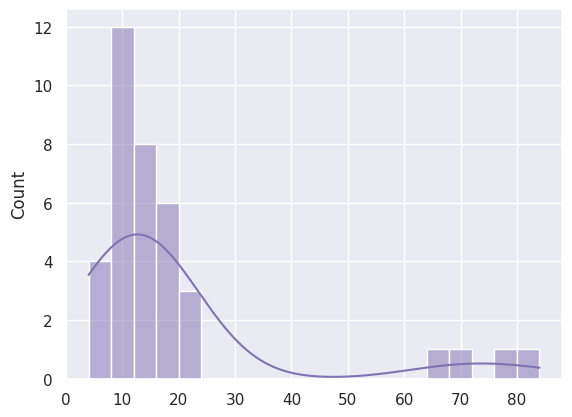

In [6]:
agg_countrys = df.groupby('Country')['Quantity'].mean().round(0).sort_values()
#print(agg_countrys)
sns.histplot(x=agg_countrys.values, kde=True, color='m')
plt.show()

In [7]:
df['quarter'] = pd.to_datetime(df['InvoiceDate']).dt.quarter
freq = df['quarter'].value_counts(normalize=True).sort_index().round(4)

In [8]:
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'])
max_date = df2['InvoiceDate'].max()

df2 = df2.dropna(subset=['CustomerID'])

rfm = df2.groupby('CustomerID').agg({'InvoiceDate': lambda x: (max_date - x.max()).days}).rename(columns={'InvoiceDate': 'Recency'})
rfm['Frequency'] = df2.groupby('CustomerID')['InvoiceNo'].nunique()

In [9]:
#total spending for the customer aquicistion. 

df2['total_sales'] = df2['Quantity'].multiply(df['UnitPrice'])
rfm['Monetary'] = df2.groupby('CustomerID')['total_sales'].sum()
rfm.reset_index()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,2,0.00
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40
...,...,...,...,...
4367,18280.0,277,1,180.60
4368,18281.0,180,1,80.82
4369,18282.0,7,3,176.60
4370,18283.0,3,16,2094.88


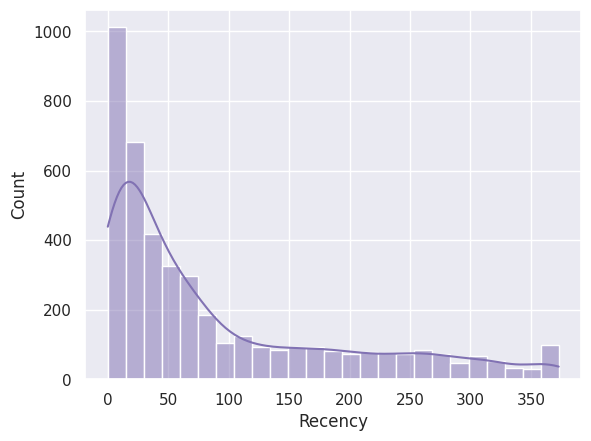

In [10]:
scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(rfm)

df2 = df2[df2['UnitPrice'] > 0]
rfm.reset_index()

sns.histplot(rfm['Recency'], kde=True, color='m')
plt.show()


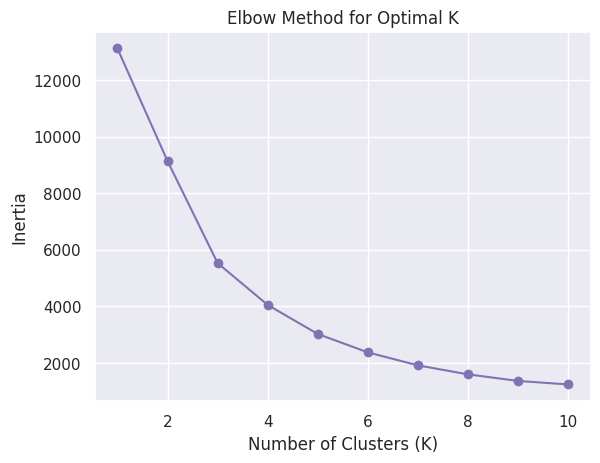

In [11]:
# K-means clustering methods, segmentation

inertia = []

K = range(1,11)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)


plt.plot(K, inertia, marker='o', color='m')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()


In [12]:
# for the k-means model

optimal_k = 4

#fit the model Kmeans
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
kmeans.fit(rfm_scaled)

rfm['Cluster'] = kmeans.labels_

rfm

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,325,2,0.00,1
12347.0,1,7,4310.00,0
12348.0,74,4,1797.24,0
12349.0,18,1,1757.55,0
12350.0,309,1,334.40,1
...,...,...,...,...
18280.0,277,1,180.60,1
18281.0,180,1,80.82,1
18282.0,7,3,176.60,0


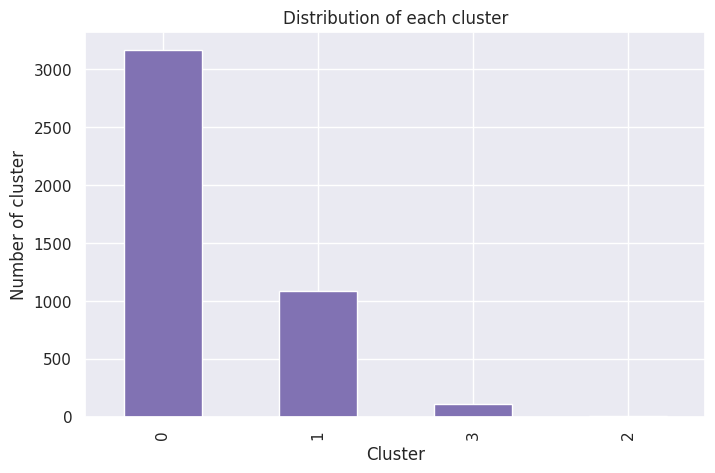

In [14]:
rfm['Cluster'].value_counts().plot(kind='bar', color='m', figsize=(8,5))

plt.title('Distribution of each cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of cluster')
plt.show()

# 4. PCA ALGORYTHM

Put on the cluster in the 2d and 3d dimension (with PCA algorythm)

In [15]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

#using the scaled data

# Aadd the pca components to the DF

rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

rfm

,Recency,Frequency,Monetary,Cluster,PCA1,PCA2
CustomerID,,,,,,
12346.0,325,2,0.00,1,-1.250581,1.972492
12347.0,1,7,4310.00,0,0.664489,-0.667714
12348.0,74,4,1797.24,0,-0.021059,-0.175201
12349.0,18,1,1757.55,0,-0.029213,-0.728563
12350.0,309,1,334.40,1,-1.236523,1.828648
...,...,...,...,...,...,...
18280.0,277,1,180.60,1,-1.127711,1.532665
18281.0,180,1,80.82,1,-0.769593,0.652917
18282.0,7,3,176.60,0,0.034431,-0.872201


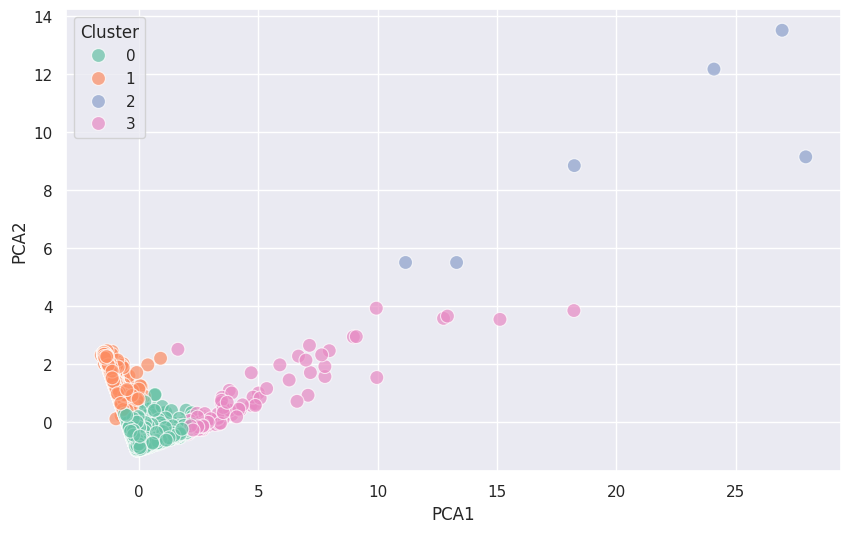

In [22]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=rfm,
                palette='Set2', s=100, alpha=0.7)

plt.show()

explainated variance:  [0.55994858 0.30067157]


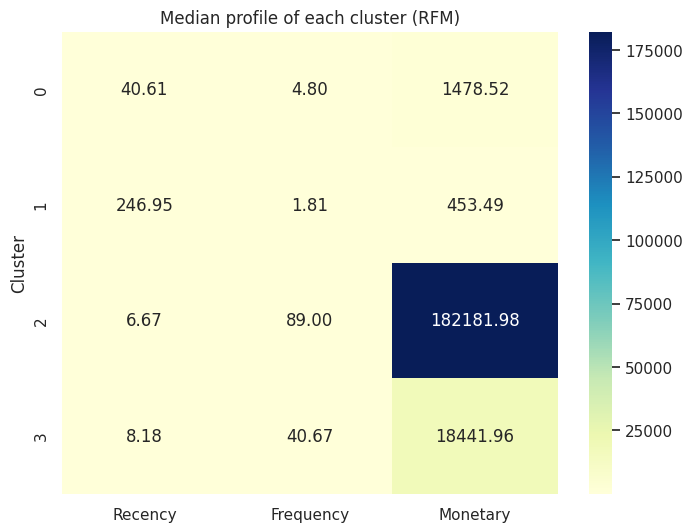

In [26]:
print(f"explainated variance:  {pca.explained_variance_ratio_}")

#ensure the numeric used to aggregation 

numeric_columns = ['Recency', 'Frequency', 'Monetary']
cluster_summary = rfm.groupby('Cluster')[numeric_columns].mean()

#print(cluster_summary)

plt.figure(figsize=(8,6))
sns.heatmap(cluster_summary, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Median profile of each cluster (RFM)')
plt.show()


#sns.set_theme(style='darkgrid')
#g = sns.jointplot(x='Frequency', y='Monetary', data=cluster_summary,
#                  kind='reg', truncate=False,
#                  color='m', height=7)

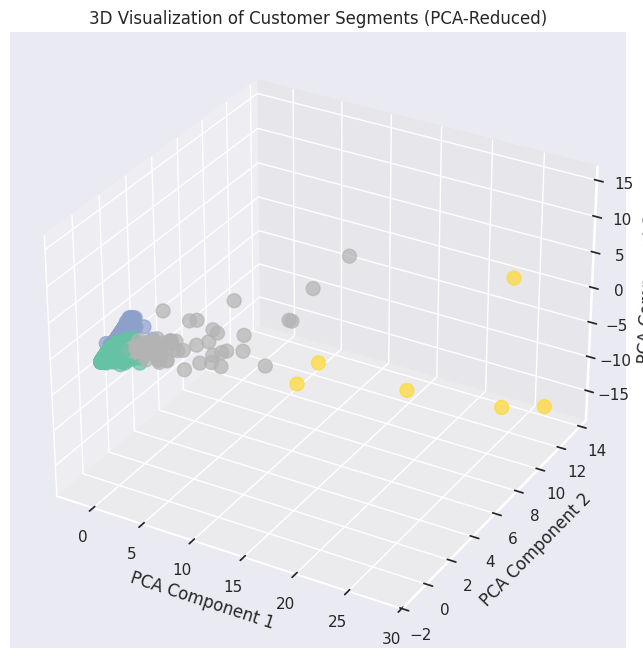

In [18]:
#set 3 dimensions 

pca_3d = PCA(n_components=3)
pca_components_3d = pca_3d.fit_transform(rfm_scaled)

rfm['PCA1'] = pca_components_3d[:, 0]
rfm['PCA2'] = pca_components_3d[:, 1]
rfm['PCA3'] = pca_components_3d[:, 2]

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# set up the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

#3D scatter plot
ax.scatter(rfm['PCA1'], rfm['PCA2'], rfm['PCA3'], c=rfm['Cluster'], cmap='Set2', s=100, alpha=0.7)

#labels and stuff
ax.set_title('3D Visualization of Customer Segments (PCA-Reduced)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()

## Whats is important to see in this dataset.

* Look, the cluster 3 and 2 with most value, in therms of sales volume. 
* In therms of the monetary sales, theses group show the most value in the dataset, using the simple way to understand how can figure better digital marketing for this public.
* Extremally important how use this consumption in the products, soo, have most value for us (companie). 
* Of first cluster (1) how work better decision to take most revenue of this group, take one case to understand more, what this bussines plan for this group.